In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
# %run ../Jane/extract_data.py

## Importing previously imputed data

In [2]:
# zillow_data = pd.read_csv('../../data/zillow_full_imputed.csv',dtype={'Zipcode':str})
# zillow_data = zillow_full.copy()
zillow_data = pd.read_csv('../../data/ZillowMarch26.csv',dtype={'Zipcode':str})
zillow_data['Date'] = pd.to_datetime(zillow_data['Date'])

In [3]:
zillow_data.set_index('Date',inplace = True)

In [4]:
zillow_data.shape

(17751, 25)

In [5]:
zillow_data.dtypes

Zipcode                  object
City                     object
State                    object
Metro                    object
County                   object
SizeRank                  int64
Rent                    float64
Year                      int64
State-County             object
total_pop               float64
households              float64
median_age              float64
median_income           float64
income_per_capita       float64
gini_index              float64
pct_poverty             float64
housing_availability    float64
home_density            float64
pct_employed            float64
pct_jobs_nightlife      float64
pct_unemployed          float64
move_within_city        float64
move_new_city           float64
avg_commute_time        float64
pct_college             float64
dtype: object

In [6]:
zillow_data.isnull().sum()

Zipcode                 0
City                    0
State                   0
Metro                   0
County                  0
SizeRank                0
Rent                    0
Year                    0
State-County            0
total_pop               0
households              0
median_age              0
median_income           0
income_per_capita       0
gini_index              0
pct_poverty             0
housing_availability    0
home_density            0
pct_employed            0
pct_jobs_nightlife      0
pct_unemployed          0
move_within_city        0
move_new_city           0
avg_commute_time        0
pct_college             0
dtype: int64

## Random Forest regressor

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [8]:
LE = LabelEncoder()
ss = StandardScaler()
features = zillow_data.drop(['Rent','State-County','State','Year',
                             'City','Metro','County','Zipcode','SizeRank'],axis = 1)
y = np.log(zillow_data['Rent'])

# features['Zipcode'] = features['Zipcode'].astype(int)

In [9]:
cat_cols = features.select_dtypes(include = object).copy()
num_cols = features.select_dtypes(exclude = object).copy()

In [10]:
for col in cat_cols.columns:
    cat_cols[col] = LE.fit_transform(cat_cols[col])

X = pd.concat([cat_cols,num_cols],axis = 1)

In [11]:
X.shape

(17751, 16)

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 500)

In [13]:
#Get the range of dates in the dataset
print(X.index[0])
print(X.index[-1])

2015-01-01 00:00:00
2020-01-01 00:00:00


In [14]:
X.columns

Index(['total_pop', 'households', 'median_age', 'median_income',
       'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [15]:
#splitting train/test sets before/after 2019
Xtrain = X.loc[X.index <'2018-08-01']
train_index = Xtrain.shape[0]
Xtest = X[train_index:]
ytrain = y[:train_index]
ytest = y[train_index:]


In [16]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=500)

In [17]:
rfc.score(Xtrain,ytrain)

0.976626614812507

In [18]:
rfc.score(Xtest,ytest)

0.9468590812368958

In [19]:
rfc.feature_importances_

array([0.00497897, 0.00537081, 0.03515586, 0.27140277, 0.18297343,
       0.04807973, 0.02373957, 0.06088358, 0.01925335, 0.02565471,
       0.01343538, 0.01458363, 0.0278218 , 0.05075466, 0.13878475,
       0.077127  ])

In [20]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

In [21]:
rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
3,median_income,0.271403
4,income_per_capita,0.182973
14,avg_commute_time,0.138785
15,pct_college,0.077127
7,housing_availability,0.060884
13,move_new_city,0.050755
5,gini_index,0.048080
2,median_age,0.035156
12,move_within_city,0.027822
9,pct_employed,0.025655


In [22]:
ypred = rfc.predict(Xtest)

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
RMSE = mean_squared_error(np.exp(ytest),np.exp(ypred), squared = False)
print(f'RMSE: {round(RMSE,2)}')


def abs_relative_error(ytest,ypred,df):
    '''returns a plot of the metro area rent errors relative to the rent price
    
    Args:
    
    ytest: pd.DataFrame, Actual rent values
    ypred: np.array, predicted rent values
    df: pd.DataFrame'''
    abs_pct_rent_error = pd.Series(np.abs((np.exp(ytest)-np.exp(ypred))/np.exp(ytest)))

    test_metros = df['Metro'].loc[df.index >=ytest.index[0]].copy()

    test_predictions = pd.concat([abs_pct_rent_error,test_metros],axis = 1)
    test_predictions.reset_index(inplace = True)
    data_error_max = test_predictions.groupby(['Date','Metro'],as_index = False)['Rent'].mean()

    fig = plt.figure(figsize =(15,10))
    sns.lineplot(data = data_error_max, x = 'Date', y = 'Rent',hue = 'Metro')
    plt.title('Mean absolute error as percentage of rent')
    plt.xlabel('Date')
    plt.ylabel('Error in percent of actual rent')
    plt.legend(loc = 'upper left')
    

RMSE: 136.2


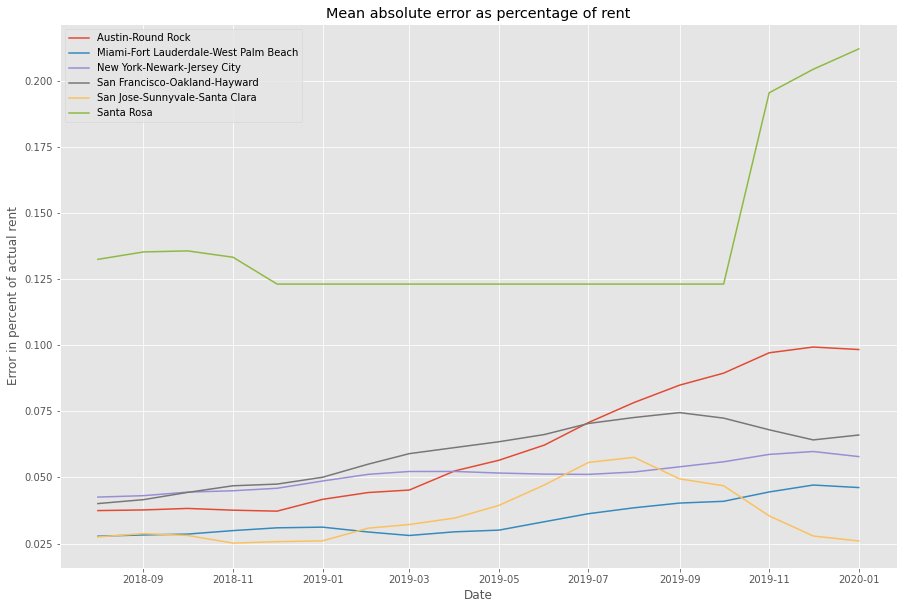

In [25]:
abs_relative_error(ytest,ypred,zillow_data)

In [26]:
from sklearn.model_selection import GridSearchCV
estimators= list(map(int,np.linspace(400,700,4)))
param_grid = {'n_estimators':estimators}


In [27]:
grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid)

In [28]:
grid.fit(Xtrain,ytrain)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [400, 500, 600, 700]})

In [29]:
grid.best_params_

{'n_estimators': 400}

In [30]:
grid.score(Xtest,ytest)

0.9468570988088564

In [31]:
grid.best_score_

0.9660350154412998

In [32]:
y_pred = grid.predict(Xtest)
print(mean_squared_error(np.exp(ytest),np.exp(ypred),squared = False))

136.2024640120734


In [33]:
rfc.set_params(**grid.best_params_)

RandomForestRegressor(n_estimators=400)

In [34]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=400)

In [35]:
rfc.score(Xtest,ytest)

0.9467553895986762

In [36]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
3,median_income,0.274908
4,income_per_capita,0.175656
14,avg_commute_time,0.137049
15,pct_college,0.082211
7,housing_availability,0.061606
13,move_new_city,0.050162
5,gini_index,0.046525
2,median_age,0.034879
9,pct_employed,0.026557
12,move_within_city,0.026377


## Writing CV to preserve time-series structure

In [37]:
X.columns

Index(['total_pop', 'households', 'median_age', 'median_income',
       'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [38]:
rent_dates = X.index.unique()

train_end = 9
test_start = train_end
test_end = test_start +3

cv_dict = {'train_score':[],
              'test_score':[],
              'RMSE':[]}

predictions = []
rfc_cv = RandomForestRegressor()
rfc_cv.set_params(n_estimators = 600)

while test_end <=len(rent_dates):


    Xtrain = X[X.index.isin(rent_dates[:train_end])]
    ytrain = y[y.index.isin(rent_dates[:train_end])]
    Xtest = X[X.index.isin(rent_dates[test_start:test_end])]
    ytest = y[y.index.isin(rent_dates[test_start:test_end])]
    rfc_cv.fit(Xtrain,ytrain)
    cv_dict['train_score'].append(rfc_cv.score(Xtrain,ytrain))
    cv_dict['test_score'].append(rfc_cv.score(Xtest,ytest))
    cv_pred = rfc_cv.predict(Xtest)
    predictions.extend(cv_pred)
    cv_dict['RMSE'].append(mean_squared_error(np.exp(ytest),np.exp(cv_pred),squared = False))
    
    print(f'Training date range: {Xtrain.index.unique().tolist()[0]} : {Xtrain.index.unique().tolist()[-1]}')
    print(f'Testing date range: {Xtest.index.unique().tolist()[0]} : {Xtest.index.unique().tolist()[-1]}')
    print(f'Random forest test score: {rfc_cv.score(Xtest,ytest)}\n')
    train_end +=3
    test_start +=3
    test_end +=3

Training date range: 2015-01-01 00:00:00 : 2015-09-01 00:00:00
Testing date range: 2015-10-01 00:00:00 : 2015-12-01 00:00:00
Random forest test score: 0.9673589787742394

Training date range: 2015-01-01 00:00:00 : 2015-12-01 00:00:00
Testing date range: 2016-01-01 00:00:00 : 2016-03-01 00:00:00
Random forest test score: 0.9672791019827667

Training date range: 2015-01-01 00:00:00 : 2016-03-01 00:00:00
Testing date range: 2016-04-01 00:00:00 : 2016-06-01 00:00:00
Random forest test score: 0.9638361961788741

Training date range: 2015-01-01 00:00:00 : 2016-06-01 00:00:00
Testing date range: 2016-07-01 00:00:00 : 2016-09-01 00:00:00
Random forest test score: 0.9577429710635671

Training date range: 2015-01-01 00:00:00 : 2016-09-01 00:00:00
Testing date range: 2016-10-01 00:00:00 : 2016-12-01 00:00:00
Random forest test score: 0.9543385592723626

Training date range: 2015-01-01 00:00:00 : 2016-12-01 00:00:00
Testing date range: 2017-01-01 00:00:00 : 2017-03-01 00:00:00
Random forest test s

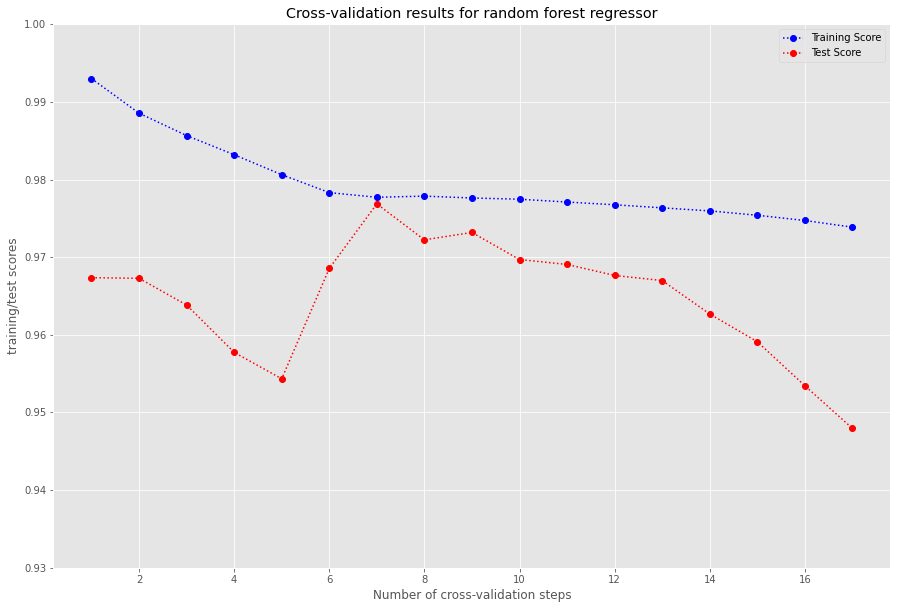

In [39]:
import matplotlib.pyplot as plt
cv_results = pd.DataFrame(cv_dict)
cv_results.index = cv_results.index +1
plt.figure(figsize = (15,10))
plt.plot(cv_results['train_score'],'bo:')
plt.plot(cv_results['test_score'],'ro:')
plt.legend(['Training Score','Test Score'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('training/test scores')
plt.title('Cross-validation results for random forest regressor')
plt.ylim([.93,1])
plt.show()


In [40]:
print(cv_results['test_score'].mean())
print(cv_results.shape[0])

0.9645863950665355
17


Text(0.5, 1.0, 'Cross-validation results for random forest regressor')

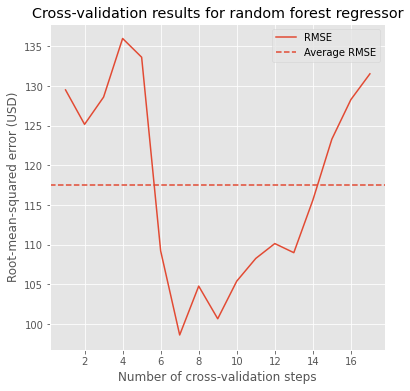

In [41]:
plt.figure(figsize = (6,6))
plt.plot(cv_results['RMSE'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('Root-mean-squared error (USD)')
plt.axhline(np.mean(cv_results['RMSE']),ls = '--')
plt.legend(['RMSE','Average RMSE'])
plt.title('Cross-validation results for random forest regressor')

In [42]:
Xtest.shape

(873, 16)

In [43]:
cv_results.index = cv_results.index+1

In [44]:
cv_results

,train_score,test_score,RMSE
2,0.992996,0.967359,129.503784
3,0.988541,0.967279,125.164911
4,0.985659,0.963836,128.603885
5,0.983195,0.957743,135.983324
6,0.980622,0.954339,133.621706
7,0.978315,0.968547,109.226252
8,0.977710,0.976864,98.638016
9,0.977861,0.972231,104.793166
10,0.977622,0.973185,100.678891
11,0.977463,0.969695,105.419669


## Random Forest on metro clusters

In [45]:
atx = pd.read_csv('../../data/clusters/au_clusters_norent.csv',dtype={'Zipcode':str})
sf = pd.read_csv('../../data/clusters/sf_clusters_norent.csv',dtype={'Zipcode':str})
ny = pd.read_csv('../../data/clusters/ny_clusters_norent.csv',dtype={'Zipcode':str})
mi = pd.read_csv('../../data/clusters/mi_clusters_norent.csv',dtype={'Zipcode':str})

In [48]:
len(atx.Clusters.value_counts())

2

In [49]:
atx.columns

Index(['Zipcode', 'City', 'State', 'Metro', 'County', 'SizeRank', 'Date',
       'Rent', 'Year', 'State-County', 'total_pop', 'households', 'median_age',
       'median_income', 'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college', 'Clusters'],
      dtype='object')

In [50]:
features.columns

Index(['total_pop', 'households', 'median_age', 'median_income',
       'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [51]:
for metro in [atx,mi,sf,ny]:
    metro['Date'] = pd.to_datetime(metro['Date'])
    metro.set_index('Date',inplace = True)


In [52]:
mi['Clusters'].nunique()

4

In [55]:
# for metro in [atx,mi,sf,ny]:
def forest_clusters(df):

    cluster_res = dict()

    for cluster in range(len(df['Clusters'].unique())):
    
        X = df.loc[df['Clusters'] == cluster].copy()
        y = np.log(X.Rent)
        X = X[features.columns].copy()
        
        Xtrain = X.loc[X.index <'2018-08-01']
        train_index = Xtrain.shape[0]
        Xtest = X[train_index:]
        ytrain = y[:train_index]
        ytest = y[train_index:]
        rfc_cluster = RandomForestRegressor(n_estimators=600)
        dict_key = str(metro)+'_cluster'+str(cluster)
        rfc_cluster.fit(Xtrain,ytrain)
        cluster_res[f'cluster{cluster}_train_score'] = rfc_cluster.score(Xtrain,ytrain)
        cluster_res[f'cluster{cluster}_test_score'] = rfc_cluster.score(Xtest,ytest)
        cluster_res[f'cluster{cluster}_test_set'] = np.array(ytest)
        cluster_res[f'cluster{cluster}_predictions'] = rfc_cluster.predict(Xtest)
        cluster_res[f'cluster{cluster}_RMSE'] = mean_squared_error(np.exp(ytest),
                                                 np.exp(cluster_res[f'cluster{cluster}_predictions'])
                                                 ,squared = False)
    return cluster_res
        

In [56]:
atx_results = forest_clusters(atx)
ny_results = forest_clusters(ny)
sf_results = forest_clusters(sf)
mi_results = forest_clusters(mi)

In [ ]:
ny['Clusters'].value_counts()

In [59]:
for cluster in range(len(ny['Clusters'].unique())):
    print(ny_results[f'cluster{cluster}_RMSE'])
    print(ny_results[f'cluster{cluster}_test_score'])
    print('\n')
    

131.30371383375143
0.8416950845455197


157.02795499111974
0.8665604095913209


141.3414836696129
0.6826632515332336




In [60]:
for cluster in range(len(sf['Clusters'].unique())):
    print(sf_results[f'cluster{cluster}_RMSE'])
    print(sf_results[f'cluster{cluster}_test_score'])
    print('\n')
    

139.9956290788516
0.8941158799783554


196.96533930681326
0.5859173661092512




In [61]:
for cluster in range(len(mi['Clusters'].unique())):
    print(mi_results[f'cluster{cluster}_RMSE'])
    print(mi_results[f'cluster{cluster}_test_score'])
    print('\n')
    

74.59826935260949
0.8020786441507558


62.72626281393348
0.8439187045133633


56.69939623337043
0.9268715658790411


102.46679915794928
0.7306784674276888




In [62]:
for cluster in range(len(atx['Clusters'].unique())):
    print(atx_results[f'cluster{cluster}_RMSE'])
    print(atx_results[f'cluster{cluster}_test_score'])
    print('\n')
    

110.55540316335956
0.2520589465629679


113.85004845111578
0.8724220412672044




In [63]:
mi['Clusters'].value_counts()

2    1098
0     915
1     854
3     793
Name: Clusters, dtype: int64

# Comparing model predictions for NY zip code

In [64]:
park_train = zillow_data.loc[(zillow_data.index <'2018-08-01')&(zillow_data['Zipcode']=='10016')]
park_test = zillow_data.loc[(zillow_data.index >='2018-08-01')&(zillow_data['Zipcode']=='10016')]

In [68]:
park_train_rent = park_train['Rent']
park_test_rent = park_test['Rent']
park_features = park_test[features.columns].copy()
park_features.shape

(18, 16)

In [69]:
park_features.shape

(18, 16)

In [71]:
park_predictions = pd.Series(rfc.predict(park_features), index = park_test_rent.index)


In [74]:
mean_squared_error(park_test_rent,np.exp(park_predictions), squared = False)

71.46944365144851

## Run get randomforest predictions using PCA results

In [75]:
zillow_pca = pd.read_csv('../../data/zillow_withPCA.csv',dtype = {'Zipcode':str})

In [76]:
zillow_pca.set_index('Date', inplace = True)

In [77]:
y = np.log(zillow_pca['Rent'])
X = zillow_pca.drop(['Zipcode','Rent'],axis = 1)

Xtrain = X.loc[X.index <'2018-08-01']
train_index = Xtrain.shape[0]
Xtest = X[train_index:]
ytrain = y[:train_index]
ytest = y[train_index:]

rfc_pca = RandomForestRegressor(n_estimators=600)

rfc_pca.fit(Xtrain,ytrain)
park_pca_test = zillow_pca.loc[(zillow_pca.index >='2018-08-01')&(zillow_pca['Zipcode']=='10016')].copy()
park_pca_test.drop(['Zipcode','Rent'],axis = 1, inplace = True)

In [78]:
pca_predictors = pd.Series(rfc_pca.predict(park_pca_test), index = park_test_rent.index)
mean_squared_error(park_test_rent,np.exp(pca_predictors), squared = False)

71.68531293768575

## Arima model for NY zipcode

Date
2015-01-01            NaN
2015-02-01            NaN
2015-03-01    3426.000000
2015-04-01    3443.000000
2015-05-01    3455.666667
2015-06-01    3479.000000
2015-07-01    3521.000000
2015-08-01    3568.333333
2015-09-01    3617.333333
2015-10-01    3638.000000
Name: Rent, dtype: float64


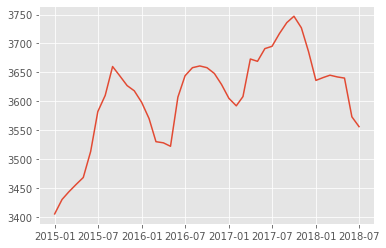

In [79]:
print(park_train_rent.rolling(3).mean().head(10))
plt.plot(park_train_rent)

(0.0, 0.5)

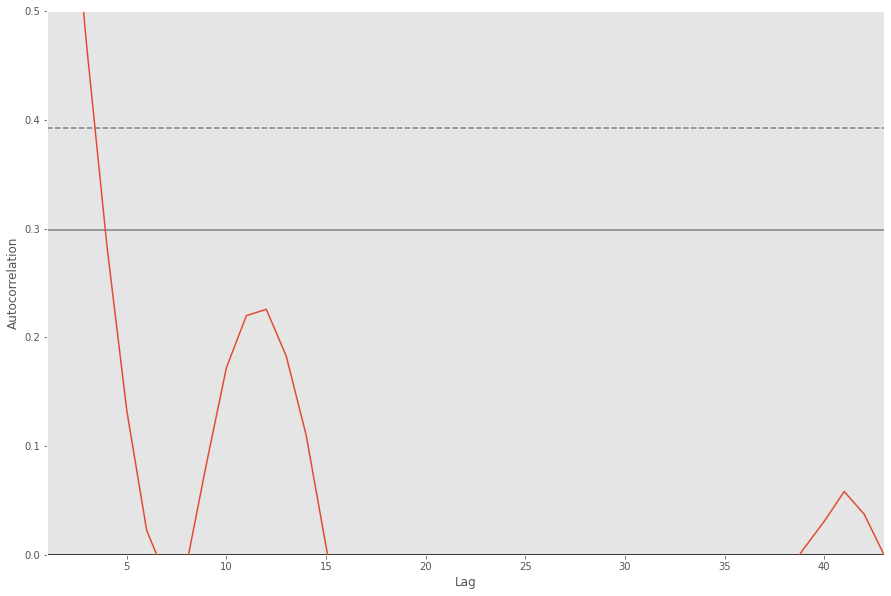

In [80]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize = (15,10))
autocorrelation_plot(park_train_rent)
plt.ylim([0,0.5])

In [81]:
from statsmodels.tsa.arima.model import ARIMA

In [82]:
training_rent = park_train_rent.copy()
training_rent.index = training_rent.index.to_period('M')
model = ARIMA(training_rent, order = (15,1,0))

In [83]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rent   No. Observations:                   43
Model:                ARIMA(15, 1, 0)   Log Likelihood                -190.894
Date:                Mon, 29 Mar 2021   AIC                            413.788
Time:                        19:03:28   BIC                            441.590
Sample:                    01-31-2015   HQIC                           423.979
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3898      0.247      1.579      0.114      -0.094       0.874
ar.L2          0.4001      0.268      1.493      0.135      -0.125       0.925
ar.L3         -0.3158      0.324     -0.976      0.3

In [84]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(park_train_rent, autolag='AIC', maxlag = 15 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [85]:
print(dfoutput)
print('Dickey-Fuller results indicate time series is non-stationary.')

Test Statistic                 -2.674761
p-value                         0.078508
#Lags Used                      1.000000
Number of Observations Used    41.000000
dtype: float64
Dickey-Fuller results indicate time series is non-stationary.


In [86]:
first_diff = np.diff(park_train_rent)
dftest = adfuller(first_diff, autolag='AIC', maxlag = 15 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 -3.815252
p-value                         0.002755
#Lags Used                      0.000000
Number of Observations Used    41.000000
dtype: float64
Taking first derivative makes it stationary


,0
count,43.000000
mean,81.273007
std,519.429800
min,-50.587052
25%,-11.161825
50%,2.268029
75%,13.921369
max,3405.000000


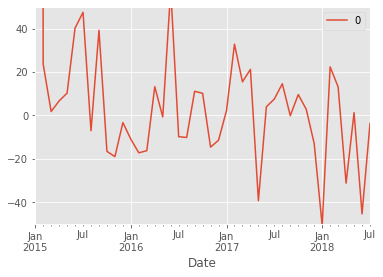

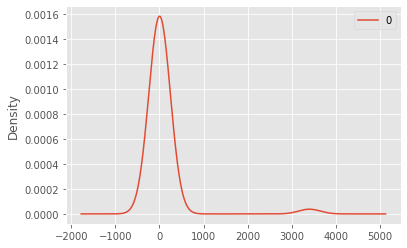

In [87]:
print(dfoutput)
print('Taking first derivative makes it stationary')

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

plt.ylim([-50,50])

residuals.plot(kind='kde')

residuals.describe()

In [104]:
# split into train and test sets
from sklearn.metrics import mean_squared_error
X = park_train_rent.values
size = int(len(X) * 0.75)
train, test = park_train_rent.values, park_test_rent.values
history = [x for x in train]
predictions = list()
# walk-forward validation
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(typ = 'levels') # steps = len(test)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs) # issue is that we add one step after
#     print('predicted=%f, expected=%f' % (yhat, obs))
    

model = ARIMA(history, order=(15,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(typ = 'levels', steps = len(test)) # steps = len(test)
# yhat = output[0]
# predictions.append(yhat)
# obs = test[t]
# history.append(obs) # issue is that we add one step after
# print('predicted=%f, expected=%f' % (yhat, obs))

for yhat in forecast:
    predictions.append(yhat)

Test RMSE: 52.734


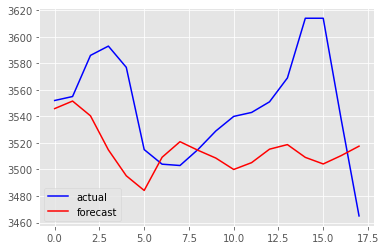

In [108]:
# evaluate forecasts
rmse = mean_squared_error(park_test_rent, predictions,squared = False)
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, color = 'blue')
plt.plot(predictions, color='red')
plt.legend(['actual','forecast'])
plt.show()

(3450.0, 3750.0)

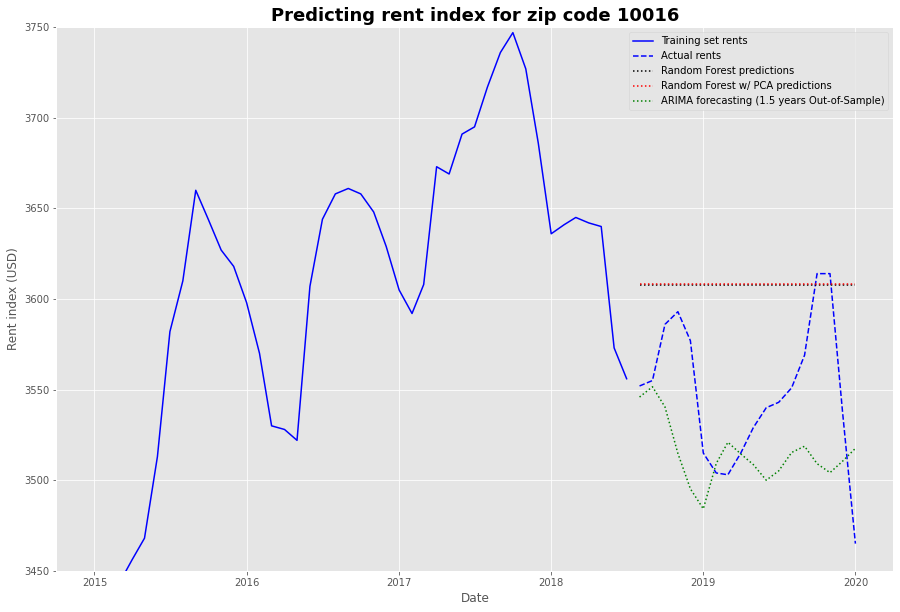

In [101]:
plt.figure(figsize = (15,10))
plt.plot(park_train_rent,'b')
plt.plot(park_test_rent,'b--')
plt.plot(np.exp(park_predictions),'k:')
plt.plot(np.exp(pca_predictors),'r:')
plt.plot(pd.Series(predictions,index = park_test_rent.index),'g:')

plt.legend(['Training set rents','Actual rents',
            'Random Forest predictions',
            'Random Forest w/ PCA predictions','ARIMA forecasting (1.5 years Out-of-Sample)'])
plt.title('Predicting rent index for zip code 10016', fontsize = 18, fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Rent index (USD)')
plt.ylim([3450,3750])